In [ ]:
!pip3 install librosa

In [81]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

2.5.0


## Dataset

We check given directory to find all available *.wav* files.

In [3]:
# helper
def contains_number(s):
    return any(i.isdigit() for i in s)

In [36]:
#check source directory and find classes
source_dir = './vox_dev_wav/wav/'
# source_dir = './audio/'
speakers = [name for name in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, name))]
print(speakers)
raw = []
for speaker in speakers:
    path = os.path.join(source_dir, speaker) + '/'
    print('checking dir:', path)
    folders = [f for f in os.listdir(path) if not f.startswith('.') ]
    for folder in folders:
        clip_path = os.path.join(path, folder) + '/'
        print(clip_path)
        clips = [f for f in os.listdir(clip_path) if f.endswith('.wav')]
        for clip in clips:
            raw.append({'speaker': speaker, 'path':clip_path+clip})

['id10009', 'id10007', 'id10006', 'id10001', 'id10008', 'id10012', 'id10015', 'id10014', 'id10013', 'id10004', 'id10003', 'id10002', 'id10005', 'id10016', 'id10011', 'id10018', 'id10020', 'id10019', 'id10010', 'id10017']
checking dir: ./vox_dev_wav/wav/id10009/
./vox_dev_wav/wav/id10009/HCGXIgKsozU/
./vox_dev_wav/wav/id10009/AtavJVP4bCk/
./vox_dev_wav/wav/id10009/x_HdUZuSusA/
./vox_dev_wav/wav/id10009/seo9TTTEoE4/
./vox_dev_wav/wav/id10009/7hpSiT9_gCE/
./vox_dev_wav/wav/id10009/JrwqvWr5_VE/
./vox_dev_wav/wav/id10009/FOFbkVlz-wQ/
./vox_dev_wav/wav/id10009/JntZkGsH2Cc/
./vox_dev_wav/wav/id10009/aFttHpeaXaQ/
./vox_dev_wav/wav/id10009/vy8sQ82o0fM/
./vox_dev_wav/wav/id10009/qdop2-gjKBQ/
./vox_dev_wav/wav/id10009/VM8gJWbQsEY/
./vox_dev_wav/wav/id10009/EJ3tyqGqYfw/
./vox_dev_wav/wav/id10009/sQIqfA-I_Ew/
checking dir: ./vox_dev_wav/wav/id10007/
./vox_dev_wav/wav/id10007/10Oe0XETA0s/
./vox_dev_wav/wav/id10007/ny4iV7xwhRM/
./vox_dev_wav/wav/id10007/HxfxcxUXPDA/
./vox_dev_wav/wav/id10007/G0lVD5d0

./vox_dev_wav/wav/id10017/6ya9UpdRCPs/
./vox_dev_wav/wav/id10017/BuecddErOwU/
./vox_dev_wav/wav/id10017/5r-26vNFeJU/
./vox_dev_wav/wav/id10017/Px9R6A3XKDM/
./vox_dev_wav/wav/id10017/xLakEK2bbQw/
./vox_dev_wav/wav/id10017/8rp9UYZp-zA/


In [173]:
df = pd.DataFrame(raw)
# df = df[:80]
print(df.shape)
df.head()

(2787, 2)


,speaker,path
0,id10009,./vox_dev_wav/wav/id10009/HCGXIgKsozU/00001.wav
1,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00009.wav
2,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00008.wav
3,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00006.wav
4,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00007.wav


## Preprocessing and Feuture Extraction

* We split the dataset as 80% train and 20% test. The split is performed per speaker and not the entire dataset
* Then, we extract MFCC and Delta features

In [174]:
# create test dataframe, keep 0.7 of each speaker as train and 0.3 as test
train_split = 0.8
df_train_list = []
df_test_list = []
for id in df['speaker'].unique():
    speaker = df.loc[df['speaker'] == id]
    #suffle and split dataset
    speaker = speaker.sample(frac=1, replace=False, random_state=42)
    train_indices = int(round(train_split*len(speaker)))
    train = speaker[:train_indices]
    test = speaker[:len(speaker) - train_indices]
    df_train_list.append(train)
    df_test_list.append(test)

df_train = pd.concat(df_train_list)
df_test = pd.concat(df_test_list)
print(df_train.shape, df_test.shape)

#df_train.groupby(['speaker']).size()

(2230, 2) (557, 2)


In [175]:
n_mfcc = 20
def extract_mfcc(row, nr_mfcc):
    signal ,sr = librosa.load(row)
    mfcc_feature = librosa.feature.mfcc(signal, n_mfcc=nr_mfcc, sr=sr, hop_length=256)
    delta_feature = librosa.feature.delta(mfcc_feature)
    
    mfcc_feature = np.mean(mfcc_feature.T,axis=0)
    delta_feature = np.mean(delta_feature.T, axis=0)

    return pd.Series([mfcc_feature, delta_feature])

In [ ]:
df_train[['mfcc','delta']] = df_train['path'].apply(lambda p: extract_mfcc(p, n_mfcc))
df_test[['mfcc','delta']] = df_test['path'].apply(lambda p: extract_mfcc(p, n_mfcc))

In [146]:
df_train.head()

,speaker,path,mfcc,delta
0,id10009,./vox_dev_wav/wav/id10009/HCGXIgKsozU/00001.wav,"[-234.83286, 133.73509, -31.300879, 38.71376, ...","[-0.22536033, -0.12889376, -0.028585024, 0.124..."
5,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00005.wav,"[-423.196, 151.2904, -20.332306, -2.9083853, -...","[0.0002549889, -0.008353452, -0.00092818623, 0..."
34,id10009,./vox_dev_wav/wav/id10009/vy8sQ82o0fM/00004.wav,"[-271.4974, 132.00212, -48.866318, 48.387047, ...","[-0.20052902, 0.018294884, 0.1554059, 0.065510..."
13,id10009,./vox_dev_wav/wav/id10009/seo9TTTEoE4/00002.wav,"[-206.58463, 144.25214, -50.279385, 31.640982,...","[-0.05777987, 0.034374237, 0.038280718, 0.0138..."
45,id10009,./vox_dev_wav/wav/id10009/EJ3tyqGqYfw/00001.wav,"[-250.60458, 139.20047, -46.59575, 34.955204, ...","[0.0495788, -0.03894916, 0.045858603, -0.10095..."


In [147]:
df_test.head()

,speaker,path,mfcc,delta
0,id10009,./vox_dev_wav/wav/id10009/HCGXIgKsozU/00001.wav,"[-234.83286, 133.73509, -31.300879, 38.71376, ...","[-0.22536033, -0.12889376, -0.028585024, 0.124..."
5,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00005.wav,"[-423.196, 151.2904, -20.332306, -2.9083853, -...","[0.0002549889, -0.008353452, -0.00092818623, 0..."
34,id10009,./vox_dev_wav/wav/id10009/vy8sQ82o0fM/00004.wav,"[-271.4974, 132.00212, -48.866318, 48.387047, ...","[-0.20052902, 0.018294884, 0.1554059, 0.065510..."
13,id10009,./vox_dev_wav/wav/id10009/seo9TTTEoE4/00002.wav,"[-206.58463, 144.25214, -50.279385, 31.640982,...","[-0.05777987, 0.034374237, 0.038280718, 0.0138..."
45,id10009,./vox_dev_wav/wav/id10009/EJ3tyqGqYfw/00001.wav,"[-250.60458, 139.20047, -46.59575, 34.955204, ...","[0.0495788, -0.03894916, 0.045858603, -0.10095..."


In [168]:
X = df_train.iloc[:, 2:4]
y = df_train.iloc[:,0]

#split dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
num_labels=len(np.unique(y))
# print(f'Number of speakers is {num_labels}')

y = encoder.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

X_train = np.hstack((X_train['mfcc'].to_list(),X_train['delta'].to_list()))
X_val = np.hstack((X_val['mfcc'].to_list(),X_val['delta'].to_list()))
print(X_train.shape)
print(X_test.shape)

(42, 40)
(22, 40)


## Deep Learning Model

In [169]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(X_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 100)               4100      
_________________________________________________________________
activation_43 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 200)               20200     
_________________________________________________________________
activation_44 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 100)             

In [171]:
## Train model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 10
num_batch_size = 8

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model_h = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, 
          validation_data=(X_val, y_val), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/10
6/6 [==============================] - 1s 33ms/step - loss: 15.4755 - accuracy: 0.5952 - val_loss: 6.4413 - val_accuracy: 0.7273

Epoch 00001: val_loss improved from inf to 6.44130, saving model to saved_models/audio_classification.hdf5
Epoch 2/10
6/6 [==============================] - 0s 12ms/step - loss: 13.4404 - accuracy: 0.6905 - val_loss: 7.0243 - val_accuracy: 0.7273

Epoch 00002: val_loss did not improve from 6.44130
Epoch 3/10
6/6 [==============================] - 0s 12ms/step - loss: 17.4811 - accuracy: 0.6905 - val_loss: 1.8688 - val_accuracy: 0.7273

Epoch 00003: val_loss improved from 6.44130 to 1.86878, saving model to saved_models/audio_classification.hdf5
Epoch 4/10
6/6 [==============================] - 0s 12ms/step - loss: 21.0795 - accuracy: 0.4524 - val_loss: 0.6670 - val_accuracy: 0.7273

Epoch 00004: val_loss improved from 1.86878 to 0.66695, saving model to saved_models/audio_classification.hdf5
Epoch 5/10
6/6 [==============================] - 0s 15m

## Check training history

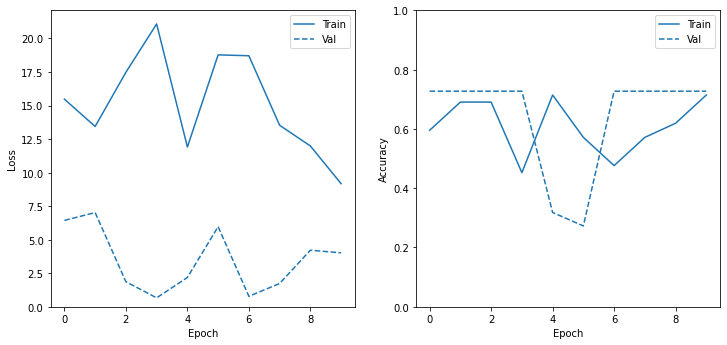

In [172]:
# import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics = ['loss', 'accuracy']#, 'f1_m', 'recall_m']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(model_h)

In [275]:
unique_speakers = df_train['speaker'].unique()
average_mfccs_list = []
for speaker in df_train['speaker'].unique():
    mfcc = df_train[df_train['speaker'] == speaker]['mfcc']
#     delta = df_train[df_train['speaker'] == s]['delta_mfccs']
#     delta2 = df_train[df_train['speaker'] == s]['delta2_mfccs']
    print(speaker, mfcc.shape)
    average_mfccs_list.append({'speaker':speaker, 
                               'avg_mfcc':mfcc.mean(),
#                                'avg_delta': delta.mean(),
#                                'avg_delta2': delta2.mean()
                              })
    
db_mfcc = pd.DataFrame(average_mfccs_list)
print(db_mfcc.head())
print(db_mfcc.shape)

id10020 (485,)
id10017 (114,)
id10016 (204,)
id10006 (102,)
id10001 (69,)
id10011 (95,)
id10002 (97,)
id10005 (51,)
id10012 (122,)
id10014 (78,)
id10013 (38,)
id10004 (84,)
id10019 (62,)
id10018 (210,)
id10015 (43,)
id10003 (132,)
id10008 (91,)
id10009 (47,)
id10007 (68,)
id10010 (38,)
   speaker                                           avg_mfcc
0  id10020  [-386.81168, 135.82, -16.45455, 50.219963, 4.3...
1  id10017  [-296.6305, 160.25072, -14.308671, 38.237274, ...
2  id10016  [-305.8967, 140.9269, -20.185614, 40.0681, -10...
3  id10006  [-371.0364, 121.5391, -24.283716, 40.122482, -...
4  id10001  [-346.49518, 141.71133, -29.163696, 42.387352,...
(20, 2)


In [276]:
# dummy approach find min euclidean distance
def search_speaker(path):
    results = pd.DataFrame()
    audio, sample_rate = librosa.load(path, res_type='kaiser_fast') 
    test_mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    test_mfccs_scaled = np.mean(test_mfccs.T,axis=0)
#     test_delta_mfccs = librosa.feature.delta(test_mfccs)
    
    def calculate_distance(id, db, keyword):
        try:
            return id, np.linalg.norm(db - keyword)
        except ValueError as e:
            return '', np.inf
        return 
        
    results['speaker'], results['distance'] = zip(*db_mfcc.apply(lambda x: calculate_distance(x['speaker'], x['avg_mfcc'], test_mfccs_scaled),axis=1))
    results = results.sort_values(by=['distance'])
    return results['speaker'].iloc[0]
    

In [278]:
#test
#keep stats
total_samples = 0
total_nr_corrects = 0

test_speakers = df_test['speaker'].unique()
test_len = len(test_speakers)

progress = 1
for speaker in test_speakers:
    samples_per_speaker = 0
    corrects_per_speaker = 0
    row = df_test[df_test['speaker'] == speaker]
    for audio_path in row['path']:
        total_samples += 1
        samples_per_speaker += 1
        best_guess = search_speaker(audio_path)
        if best_guess == speaker:
            corrects_per_speaker += 1
            total_nr_corrects += 1
    print(f'{progress}/{test_len} speaker {speaker}, \
    accuracy {corrects_per_speaker/samples_per_speaker} ({corrects_per_speaker}/{samples_per_speaker})')
    progress +=1

1/20 speaker id10020,     accuracy 0.7586206896551724 (88/116)
2/20 speaker id10017,     accuracy 0.1724137931034483 (5/29)
3/20 speaker id10016,     accuracy 0.125 (6/48)
4/20 speaker id10006,     accuracy 0.3333333333333333 (10/30)
5/20 speaker id10001,     accuracy 0.0 (0/15)
6/20 speaker id10011,     accuracy 0.3 (9/30)
7/20 speaker id10002,     accuracy 0.6153846153846154 (16/26)
8/20 speaker id10005,     accuracy 0.0 (0/17)
9/20 speaker id10012,     accuracy 0.2571428571428571 (9/35)
10/20 speaker id10014,     accuracy 0.29411764705882354 (5/17)
11/20 speaker id10013,     accuracy 0.35714285714285715 (5/14)
12/20 speaker id10004,     accuracy 0.13333333333333333 (2/15)
13/20 speaker id10019,     accuracy 0.5 (7/14)
14/20 speaker id10018,     accuracy 0.15384615384615385 (8/52)
15/20 speaker id10015,     accuracy 0.2857142857142857 (2/7)
16/20 speaker id10003,     accuracy 0.4864864864864865 (18/37)
17/20 speaker id10008,     accuracy 0.4166666666666667 (10/24)
18/20 speaker id100

In [279]:
print(f'accuracy {total_nr_corrects/total_samples}')

accuracy 0.3734290843806104


In [260]:
nr_corrects

116

In [261]:
total_samples

557

In [262]:
df_test.shape

(557, 2)

In [ ]:
X = np.array(df['mfcc'].tolist())# 'delta_mfccs', 'delta2_mfccs']]
y = np.array(df['speaker_encoded'].tolist())
print(f'X shape: {X.shape}, Y shape: {y.shape}')

In [ ]:
#split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape)

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
### No of classes
num_labels=len(np.unique(y))
num_labels
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))
y

## Testing Some Test Audio Data
Steps

* Preprocess the new audio data
* predict the classes
* Invere transform your Predicted Label

In [ ]:
filename= source_dir + 'brian_greene/clip_5.wav'
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predicted_label=model.predict_classes(mfccs_scaled_features)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class




print('ela')
p=model.predict(mfccs_scaled_features)
print(p)

In [ ]:
# Load an audio file
audio_file = 'audio/sample1.wav'

In [ ]:
# Play audio file
ipd.Audio(audio_file)

In [ ]:
signal ,sr = librosa.load(audio_file)

In [ ]:
signal.shape

In [ ]:
# Extract MFCCs
mfccs = librosa.feature.mfcc(signal, n_mfcc=13, sr=sr)

In [ ]:
mfccs.shape

In [ ]:
# Visualize MFCCs
plt.figure(figsize=(25,10))
librosa.display.specshow(mfccs,
                       x_axis='time',
                       sr=sr)
plt.colorbar(format="%+2f")
plt.show()

In [ ]:
# Calculate delta and delta2 MFCCs
delta_mfccs = librosa.feature.delta(mfccs)
delta2_mfccs = librosa.feature.delta(mfccs, order=2)

In [ ]:
delta_mfccs.shape

In [ ]:
plt.figure(figsize=(25,10))
librosa.display.specshow(delta_mfccs,
                       x_axis='time',
                       sr=sr)
plt.colorbar(format="%+2f")
plt.show()

In [ ]:
plt.figure(figsize=(25,10))
librosa.display.specshow(delta2_mfccs,
                       x_axis='time',
                       sr=sr)
plt.colorbar(format="%+2f")
plt.show()

In [ ]:
#unique audio feature concatenate delta and delta2 mfccs
comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))

In [ ]:
comprehensive_mfccs.shape